In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle
import keras
from sklearn.metrics import f1_score
import cv2
from tqdm import tqdm
from keras.utils import to_categorical

import os
import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "./hub_dataset"
BOTTLE_DIR = "./bottleneck"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/validation"
file_tail = "_https~tfhub.dev~google~imagenet~pnasnet_large~feature_vector~1.txt"

In [3]:
NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(BOTTLE_DIR + "/*/*.txt")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.1)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.copy(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.copy(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.txt"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.txt"))
    print("Validation:",NUM_VAL_EXAMPLES )

creating data directories for training and validation


In [4]:
def features_from_bottles(bottles):
    X = []
    y = []
    for bottle in tqdm(bottles):
        label = bottle.split("/")[-1].replace(file_tail, "")
        line = open(bottle).readlines()
        X.append( np.loadtxt(line[0].split(','), dtype=np.float32) )
        y.append(label)
        
    X = np.array(X)
    return (X, y)

In [5]:
bottles = glob.glob(VAL_DIR + "/*.txt")
x_val, y_val = features_from_bottles(bottles)


bottles = glob.glob(TRAIN_DIR + "/*.txt")
x_train, y_train = features_from_bottles(bottles)


100%|██████████| 145134/145134 [50:29<00:00, 47.90it/s]


In [12]:
mvc_label = pd.read_csv( './mvc_label.csv', index_col='filename')
mvc_label.head(10)

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,BalconetteBras,Bandeau,BandeauBras,...,Yellow,ZebraPrint,Zipper,fiftyU,halfZip,hundred1U,hundred2O,hundred2U,quarter3Zip,quarterZip
filename,,,,,,,,,,,,,,,,,,,,,
p7258521_s3163710_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
cols=[8, 9, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 29, 30, 31, 36, 37, 54, 55, 58, 61, 62, 63, 64, 72, 74, 80, 90, 92, 95, 96, 104, 112, 119, 123, 125, 126, 129, 131, 134, 136, 138, 139, 140, 141, 146, 151, 159, 160, 161, 165, 175, 182, 189, 195, 197, 199, 202, 208, 209, 210, 211, 212, 220, 222, 234, 241, 242, 244, 247, 248, 255, 258, 260, 261, 262, 263]
new_cols=[idx-1 for idx in cols]
mvc_label.columns[new_cols]

Index(['BalconetteBras', 'Bandeau', 'BandeauBras', 'Beige', 'Black', 'Blue',
       'BoxerBriefs', 'Boxers', 'BoyShorts', 'BraletteBras', 'Bras', 'Brief',
       'Bronze', 'Brown', 'Burgundy', 'Camis', 'Camisoles', 'Compression',
       'CompressionBras', 'ConvertibleBras', 'Corset', 'Cotton',
       'CoverUpDresses', 'CoverUps', 'Crosstraining', 'DemiBras',
       'EnhancedBras', 'FullCoverageBras', 'Gold', 'Gray', 'Green', 'Hosiery',
       'Lingerie', 'Mahogany', 'MinimizerBras', 'MoldedCupBras', 'NursingBras',
       'Olive', 'OnePieceSwimsuits', 'Orange', 'PaddedBras', 'PajamaBottoms',
       'PajamaSets', 'PajamaTops', 'Panties', 'Pink', 'PlungeBras', 'Purple',
       'PushUpBras', 'Racerback', 'Red', 'Salomon', 'ShelfBras', 'Silver',
       'Snow', 'SoftCupBras', 'SportsBras', 'StraplessBras', 'SwimDresses',
       'SwimSets', 'SwimsuitBottoms', 'SwimsuitTops', 'Synthetic', 'Taupe',
       'Thongs', 'UnderwireBras', 'WaterResistant', 'Waterproof', 'White',
       'WindResistant'

In [14]:
mvc_label.drop(mvc_label.columns[new_cols],axis=1,inplace=True)
mvc_label.sample(10)

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,Banded,Beaded,Blouses,...,Wool,Workout,WorkoutPants,WrapDresses,Wraps,WrinkleResistant,ZebraPrint,Zipper,halfZip,quarterZip
filename,,,,,,,,,,,,,,,,,,,,,
p8579450_s3280336_v5.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p8588064_s3296331_v0.jpg,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
p8298500_s2624672_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p8565811_s3251029_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p8645109_s3429875_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p8557110_s3228756_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p7595977_s1036806_v2.jpg,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
p7695245_s3323359_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p8547933_s3207561_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [15]:
y_train = np.array([mvc_label.loc[label] for label in y_train])
y_val   = np.array([mvc_label.loc[label] for label in y_val])

In [16]:
y_train.shape

(145134, 187)

In [17]:
y_val.shape

(16126, 187)

In [18]:
np.savez_compressed('./mvc_train_kor', x_train=x_train, y_train=y_train)
np.savez_compressed('./mvc_valid_kor', x_val=x_val, y_val=y_val)

In [19]:
print("Validation examples:", len(x_val))
print("Y val examples:", len(y_val))
print("Train examples:", len(x_train))
print("Y examples:", len(y_train))

Validation examples: 16126
Y val examples: 16126
Train examples: 145134
Y examples: 145134


In [20]:
# Plotting on keras training
# https://github.com/stared/livelossplot/
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,4))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="train loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        ax1.set_title("Loss Curves")
        ax1.set_ylabel("Loss")
        ax1.set_xlabel("Epochs")
        
        ax2.plot(self.x, self.acc, label="train accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        ax2.set_title("Accuracy Curves")
        ax2.set_ylabel("Accuracy")
        ax2.set_xlabel("Epochs")
        
        plt.show();

plot_losses = PlotLearning()

In [21]:
model = Sequential()
model.add(Dense(1024, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.add(Dense(5, activation='softmax'))
#model.add(GlobalAveragePooling2D(input_dim=x_train.shape[1:]))
#model.add(Dense(5 , activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4424704   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 187)               191675    
Total params: 4,620,475
Trainable params: 4,618,427
Non-trainable params: 2,048
_________________________________________________________________


https://github.com/suhongs/dog-project/blob/master/dog_app.ipynb

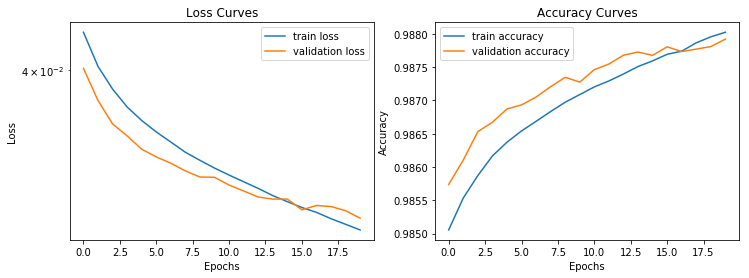

In [24]:
filepath="./model/hub_kr/weights-improvement-{epoch:02d}-l_{val_loss:.4f}-{loss:.4f}_-ac_{val_acc:.4f}.hdf5"
mc_top = ModelCheckpoint(filepath,
                         monitor='val_loss', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)


history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20,
                    batch_size=1024, callbacks=[mc_top, plot_losses], verbose=1)

In [25]:
preds = model.predict(x_val)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

result = preds.reshape(-1) == y_val.reshape(-1)
acc_on_test = sum(result)/len(result)
print("Accuracy", acc_on_test)

Accuracy 0.987921654405


In [26]:
for weights in glob.glob('./model/hub_kr/*weights-improvement*.hdf5'):
    print(weights)
    model.load_weights(weights)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    scores = model.evaluate(x_val, y_val, verbose=0)
    y_pred = model.predict(x_val)
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    f1_value = f1_score(y_val, y_pred, average='samples')
    print("Scores:", scores, "F1:", f1_value)
    print("-\n")

./model/hub_kr/weights-improvement-06-l_0.0349-0.0363_-ac_0.9869.hdf5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Scores: [0.03487265680267581, 0.98693377774568702] F1: 0.586361732873
-

./model/hub_kr/weights-improvement-01-l_0.0401-0.0425_-ac_0.9857.hdf5
Scores: [0.04011099011816651, 0.9857379835813731] F1: 0.52492136903
-

./model/hub_kr/weights-improvement-11-l_0.0334-0.0339_-ac_0.9875.hdf5
Scores: [0.033355673757057974, 0.98746336400915458] F1: 0.621300396225
-

./model/hub_kr/weights-improvement-07-l_0.0345-0.0357_-ac_0.9871.hdf5
Scores: [0.034527525916773216, 0.98705150173154843] F1: 0.600031065283
-

./model/hub_kr/weights-improvement-10-l_0.0338-0.0343_-ac_0.9873.hdf5
Scores: [0.033770566875962617, 0.98727534059169464] F1: 0.613057820017
-

./model/hub_kr/weights-improvement-14-l_0.0326-0.0328_-ac_0.9877.hdf5
Scores: [0.032626092872851155, 0.98772732937704111] F1: 0.623457723881
-

./model/hub_kr/weights-improvement-05-l_0.0353-0.0369_-ac_0.9869.hdf5
Scores: [0.035299607277568881, 0.98687209952015087] F1: 0.596319206449
-

./model/hub_kr/weights-improvement-04-l_0.0361-0.0377_-ac_0.9867.h

In [27]:
attr=pd.Series(mvc_label.columns.values)

In [308]:
val_bottles = glob.glob('./hub_dataset/validation/*.txt')
x_val.shape[0]

16126

In [309]:
len(val_bottles)

16126

In [579]:
i = random.randint(0, x_val.shape[0])
im_path = val_bottles[i].replace(file_tail, "").replace("hub_dataset/validation/", "rename/")
print(im_path)
pred = model.predict(x_val[i:i+1])
indexes = np.where(pred[0,:] > 0.5)

./rename/p8512602_s3123909_v3.jpg


In [580]:
attr.iloc[indexes]

53     FieldJacket
81     LongSleeves
108      Polyester
dtype: object

In [581]:
actual_idx = np.where(y_val[i] > 0)[0]
attr.iloc[actual_idx]

53     FieldJacket
81     LongSleeves
108      Polyester
112      RainCoats
dtype: object

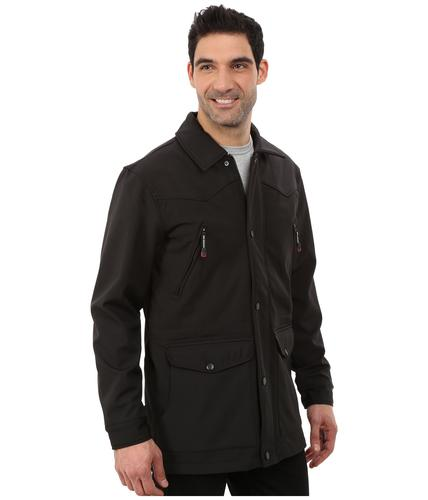

In [582]:
from IPython.display import Image
Image(im_path)

In [588]:
showfit = np.load('../showfit/showfit_exclude_val.npz')

In [589]:
shofit_x = showfit['x_val']
shofit_y = showfit['y_val']

In [590]:
showfit_bottles = glob.glob('../showfit/hub_dataset/validation/*/*.txt')
shofit_x.shape[0]

15328

In [804]:
i = random.randint(0, shofit_x.shape[0])
im_path = showfit_bottles[i].replace(file_tail, "").replace("../showfit/hub_dataset/validation/", "../showfit/data/")
print(im_path)
pred = model.predict(shofit_x[i:i+1])
indexes = np.where(pred[0,:] > 0.5)

../showfit/data/DRESS/16453_1_0.jpg


In [805]:
showfit_pred = model.predict(shofit_x[i:i+1])
indexes = np.where(showfit_pred[0,:] > 0.5)
attr.iloc[indexes]

Series([], dtype: object)

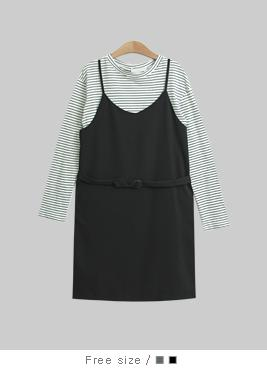

In [806]:
Image(im_path)